In [28]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model


In [32]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    # todo
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)     
    
    if ds.PatientPosition not in ['AP', 'PA']:
        msg = 'Invalid Image. Reason: Patien Position is {}'.format(ds.PatientPosition)
        print(msg)
        return None, msg
    
    # https://wiki.cancerimagingarchive.net/display/Public/DICOM+Modality+Abbreviations
    if ds.Modality != 'DX':
        msg = 'Invalid Image. Reason: Modality is {}'.format(ds.Modality)
        print(msg)
        return None, msg
    
    # Must be a chest/RIBCAGE x-ray image
    # See a list of BodyPartExamined values below:
    # http://dicom.nema.org/dicom/2013/output/chtml/part16/chapter_L.html
    if ds.BodyPartExamined not in ['CHEST', 'RIBCAGE']:
        msg = 'Invalid Image. Reason: body part is {}'.format(ds.BodyPartExamined)
        print(msg)
        return None, msg
    
    img = ds.pixel_array
    return img, ds.StudyDescription

    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    # todo
    
    rescale = 1. / 255.0
    
    proc_img = img * rescale
    proc_img = resize(proc_img, (img_size[1], img_size[2]), anti_aliasing=False)
    proc_img = proc_img.reshape((img_size[0], img_size[1], img_size[2], 1))

    # Reformat data to match the input data format of the model
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    
    # https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras/47556342#47556342
    proc_img = preprocess_input(proc_img)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    
    with open("my_model.json", "r") as json_file:
        model_json = json_file.read()
        
    model = model_from_json(model_json)
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo  
    
    prob = model.predict(img, verbose = True)
    pred = prob > thresh
    prediction = pred[0][0]
    
    return prediction 

Load file test1.dcm ...
1/1 [==============================] - 0s 139ms/step
---------------
Load file test2.dcm ...
1/1 [==============================] - 0s 34ms/step
---------------
Load file test3.dcm ...
1/1 [==============================] - 0s 35ms/step
---------------
Load file test4.dcm ...
1/1 [==============================] - 0s 37ms/step
---------------
Load file test5.dcm ...
Invalid Image. Reason: Modality is CT
Load file test6.dcm ...
Invalid Image. Reason: Patien Position is XX


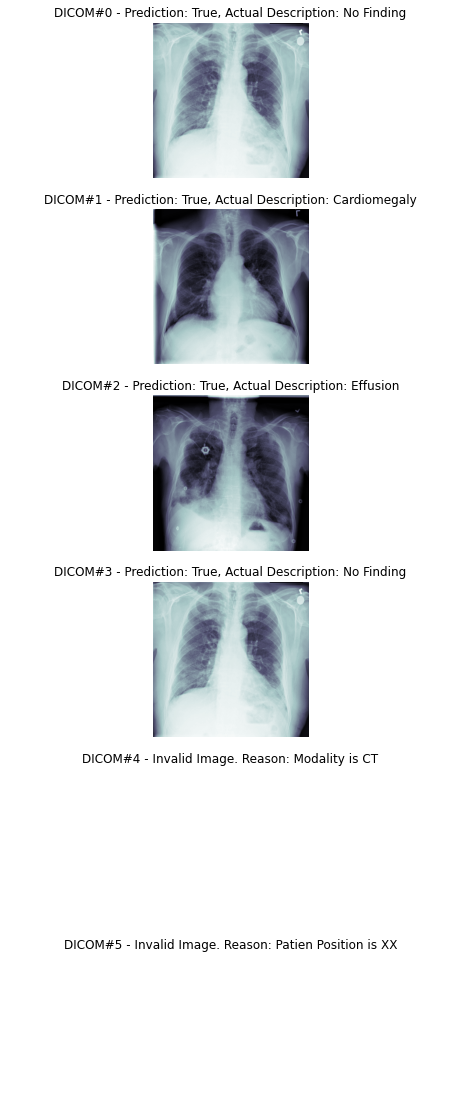

In [31]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "my_model.json" #path to saved model
weight_path= "{}_my_model.best.hdf5".format('xray_class') #path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = None # loads the mean image value they used during training preprocessing
img_std = None # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.39 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
fig, m_axs = plt.subplots(len(test_dicoms), 1, figsize = (8, 20))
    
for idx, (cur_dicom, c_ax) in enumerate(zip(test_dicoms, m_axs.flatten())):
    c_ax.axis('off')
    
    img = np.array([])
    img, desc = check_dicom(cur_dicom)
    if img is None:
        c_ax.set_title('DICOM#{} - {}'.format(idx, desc))
        continue
        
    img_proc = preprocess_image(img, img_mean, img_std, IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
        
    c_ax.imshow(img, cmap='bone')
    c_ax.set_title('DICOM#{} - Prediction: {}, Actual Description: {}'.format(idx, pred, desc))
    
    
    print('---------------')